# **🐧 Train Baseline Penguin Classifer** 

**📌 Overview:** 
In this notebook we’ll run through the first three stages of the ML lifecycle using the Palmer Penguins dataset. Our goal is to build a clean, low-latency baseline pipeline that predicts a penguin’s species (Adelie, Chinstrap, Gentoo) from only two numeric features: bill length and bill depth

1. **Data Ingestion** — load the dataset 
2. **Data Preparation** — clean and encode features, then create train/validation/test splits  
3. **Model Training & EDA** — 
    - Explore relationships between features and species 
    - Train a Logistic Regression (LR) classifier as baseline model
    - Evaluate performance on test set
#
**📦 Deliverable:**
- `sklearn` Pipeline with preprocessing and minimal feature Logistic Regression model
- Baseline performance metrics:
    - Accuracy, precision, recall, f1-score
    - Confusion matrix


In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

### **1️⃣ Data Ingestion**

Load and preview the **Palmer Penguins** dataset from seaborn 

In [5]:
pd.set_option("display.max_columns", None)

# Load raw dataset into pandas 
penguins = sns.load_dataset("penguins")

print(f"ROWS, COLUMNS: {penguins.shape}")
penguins.head()

ROWS, COLUMNS: (344, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [3]:
# Count missing values
print(f"{penguins.isna().sum()}\n")

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64



In [4]:
# Summary of numeric columns 
penguins.describe().T

,count,mean,std,min,25%,50%,75%,max
bill_length_mm,342.0,43.921930,5.459584,32.1,39.225,44.45,48.5,59.6
bill_depth_mm,342.0,17.151170,1.974793,13.1,15.600,17.30,18.7,21.5
flipper_length_mm,342.0,200.915205,14.061714,172.0,190.000,197.00,213.0,231.0
body_mass_g,342.0,4201.754386,801.954536,2700.0,3550.000,4050.00,4750.0,6300.0


In [5]:
# Unique values for categorical columns
for col in penguins.select_dtypes("object"):
    print(f"{col}: {penguins[col].unique()}")

# Summary of categorical columns 
penguins.describe(include="object").T

species: ['Adelie' 'Chinstrap' 'Gentoo']
island: ['Torgersen' 'Biscoe' 'Dream']
sex: ['Male' 'Female' nan]


,count,unique,top,freq
species,344,3,Adelie,152
island,344,3,Biscoe,168
sex,333,2,Male,168


In [6]:
# View class imbalance
penguins["species"].value_counts()

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

### **2️⃣ Data Preparation**

To prepare our data for training, we must:
- Impute missing numerics with median and missing categoricals with mode
- One-hot encode categoricals
- Scale numeric features to mean 0 / std 1
- Train/test split (80/20)

In [8]:
# Separate target from features 
y = penguins["species"].copy()
X = penguins.copy().drop(columns=["species", "bill_length_mm", "bill_depth_mm", "island"])

# Identify column types 
num_cols = X.select_dtypes(exclude="object").columns
cat_cols = X.select_dtypes(include="object").columns

# Build preprocessing pipelines
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(missing_values=np.nan, strategy="median")), 
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")), 
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Run pipelines on respective column types
preprocessor = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

# Split dataset into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20, 
    stratify=y,
    random_state=42
)

print("TRAIN SET:", X_train.shape, y_train.value_counts(normalize=True).round(2))
print("TEST SET:", X_test.shape, y_test.value_counts(normalize=True).round(2))

TRAIN SET: (275, 3) species
Adelie       0.44
Gentoo       0.36
Chinstrap    0.20
Name: proportion, dtype: float64
TEST SET: (69, 3) species
Adelie       0.43
Gentoo       0.36
Chinstrap    0.20
Name: proportion, dtype: float64


### **3️⃣ Model Training & EDA**

In this step, we will visualise key feature interactions and fit our 
baseline classifier wrapped in an inference-ready `Pipeline`

**We will:**
1. Explore data through plot visualizations 
2. Build a single `Pipeline` that chains the **preprocessor** (defined above)
    and a **multinomial Logistic Regression** model
3. Train on the 80 % train set and evaluate on the held‑out 20 % test set

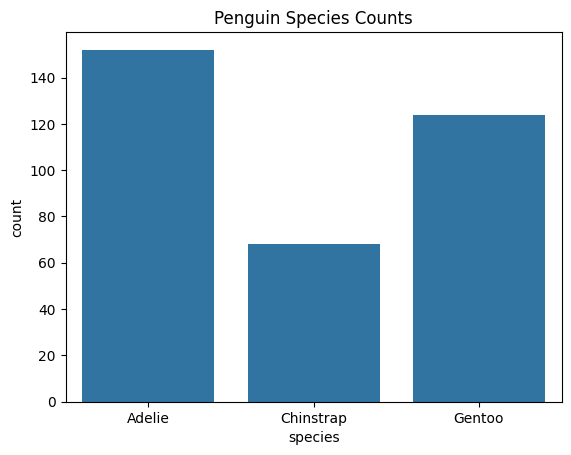

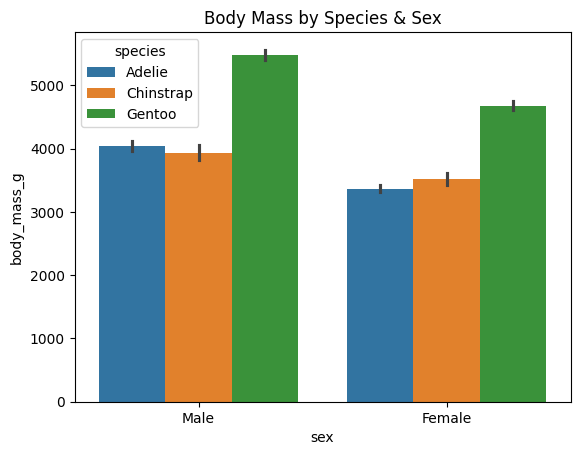

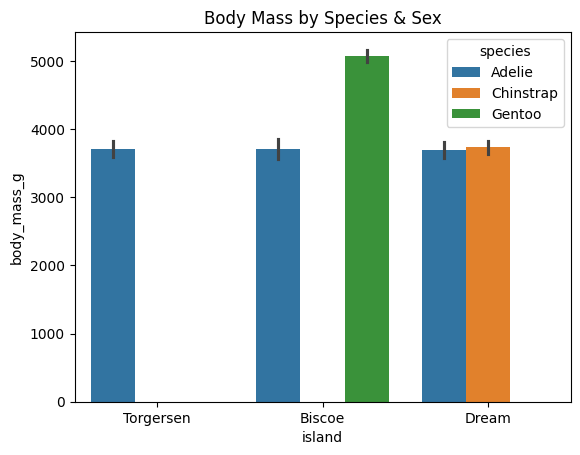

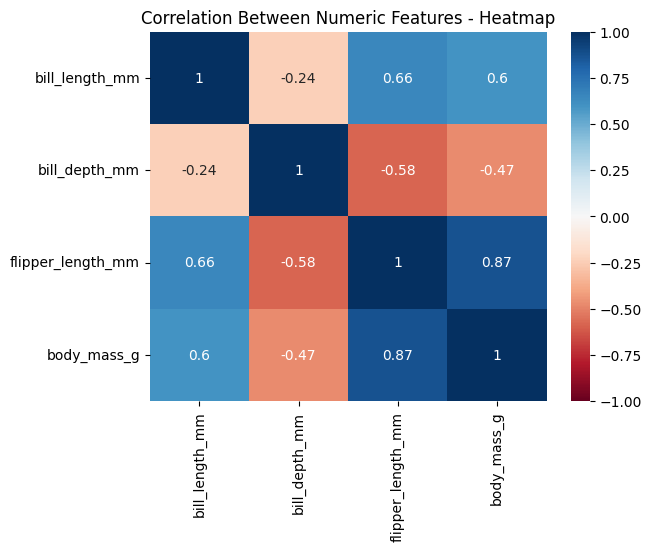

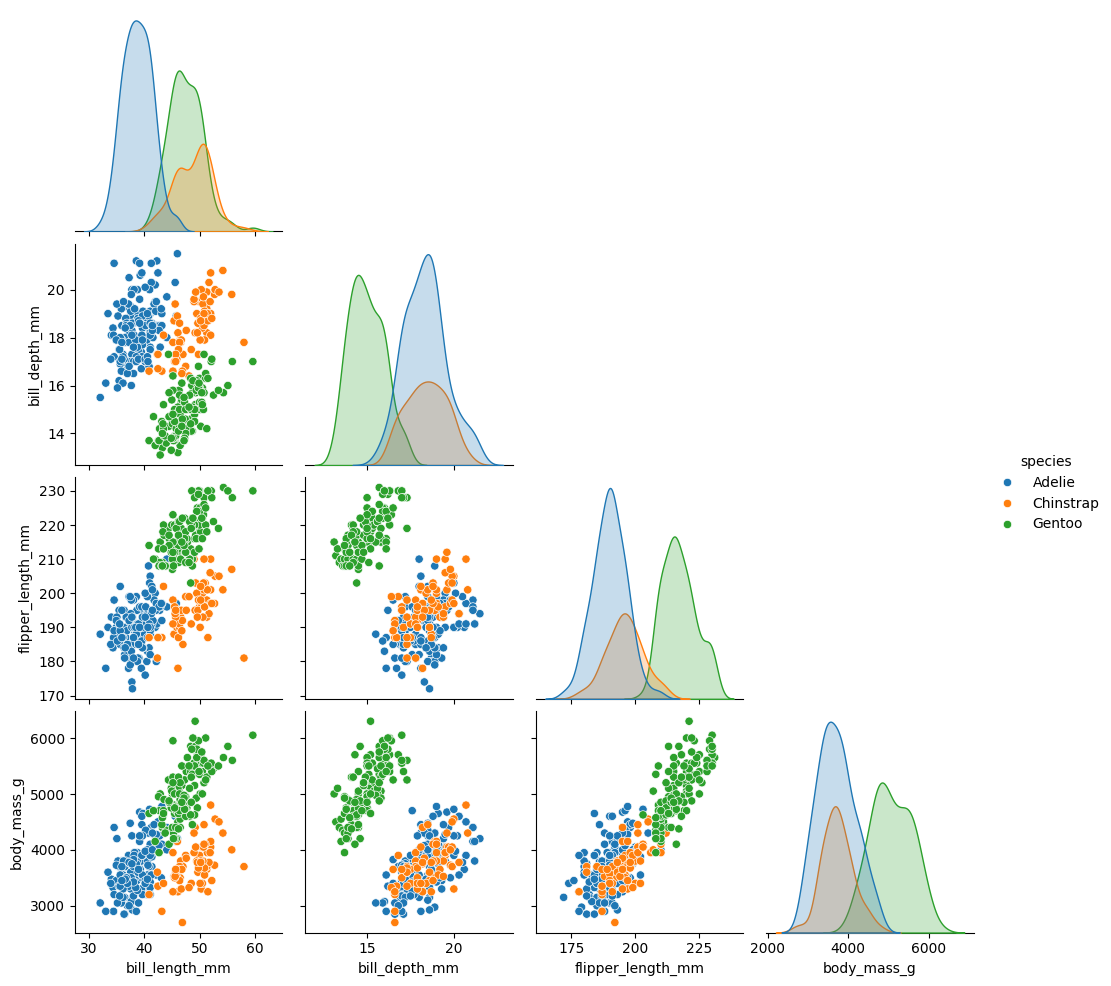

In [9]:
# Class distribution
sns.countplot(x="species", data=penguins)
plt.title("Penguin Species Counts")
plt.show()

# Categorical and numeric 
sns.barplot(x="sex", y="body_mass_g", hue="species", data=penguins)
plt.title("Body Mass by Species & Sex")
plt.show()

sns.barplot(x="island", y="body_mass_g", hue="species", data=penguins)
plt.title("Body Mass by Species & Sex")
plt.show()

# Correlation heatmap (numeric)
sns.heatmap(
    penguins.copy().drop(columns=["species"]).select_dtypes(exclude="object").corr(), 
    vmin=-1, 
    vmax=1, 
    cmap="RdBu", 
    annot=True
)
plt.title("Correlation Between Numeric Features - Heatmap")
plt.show()

# Pairplot for overall numeric relationships
sns.pairplot(penguins, hue="species", corner=True)
plt.show()

#### **Metrics**

**Precision** - of the penguins species predicted, what fraction were correct? (care about correctness of predictions) 
- "of all the patients we diagnosed with a cancer, how many actually had it?"

**Recall** - of the actual penguin species, what fraction were predicted? (care about not missing any real cases) 
- "of all the patients who truly had the cancer, how many did we successfully diagnose?"

**F1-Score** - harmonic mean of precision and recall 

---

Precision **high**, Recall **low** -> model is careful and conservative \
Recall **high**, Precision **low** -> model catches everything but overpredicts 

TEST REPORT:
               precision    recall  f1-score   support

      Adelie       0.71      0.80      0.75        30
   Chinstrap       0.40      0.29      0.33        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           0.77        69
   macro avg       0.70      0.70      0.69        69
weighted avg       0.75      0.77      0.76        69



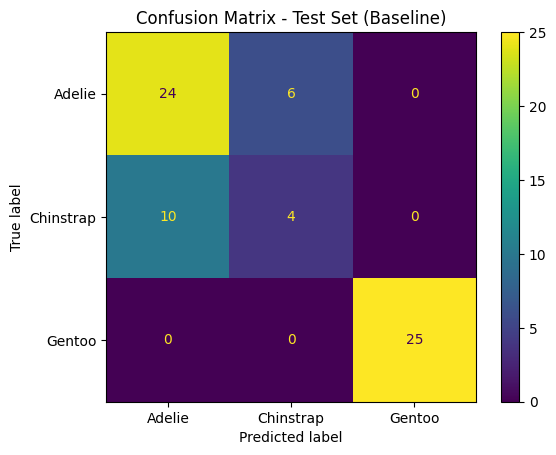

In [10]:
# Define hyperparameters 
params = {
    "solver": "lbfgs",
    "max_iter": 200,
    "C": 1.0
}

# Create full inference pipeline 
clf = Pipeline([
    ("preprocess" , preprocessor),
    ("model", LogisticRegression(**params))
])

# Train the model
clf.fit(X_train, y_train)

# Evaluate on test set
y_pred = clf.predict(X_test)
test_report = classification_report(y_test, y_pred)
print("TEST REPORT:\n", test_report)

# Collect metrics for logging 
test_report_dict = classification_report(y_test, y_pred, output_dict=True)
metrics = {
    "test_accuracy":  test_report_dict["accuracy"],
    "test_f1_macro":  test_report_dict["macro avg"]["f1-score"],
    "test_recall_Adelie":    test_report_dict["Adelie"]["recall"],
    "test_recall_Chinstrap": test_report_dict["Chinstrap"]["recall"],
    "test_recall_Gentoo":    test_report_dict["Gentoo"]["recall"],
}

# Visualize confusion matrix 
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax)
plt.title("Confusion Matrix - Test Set (Baseline)")
plt.show()

# **🧩 Versioning with Git & DVC**

**Why DVC (on top of Git)?**

Git tracks code. \
DVC tracks data & model artifacts and pipelines so you can reproduce a model exactly.

**What we’ll do:**
1. Clean up subfolder .gitignore and prep folders 
2. Install + init DVC with a local remote 
3. Download and track the dataset with DVC 
4. Add a tiny training script; make a DVC stage and run it 
5. Prove reproducibility (delete model → restore with DVC)

### **1. Pre-flight: remove local .gitignore and prep folders**

In [12]:
%%bash
set -e

# 1) Remove any .gitignore in THIS folder tree (keeps root .gitignore intact).
#    This avoids "bad DVC file name is git-ignored" errors from subfolder rules.
find . -maxdepth 2 -type f -name ".gitignore" ! -path "./.gitignore" -print0 \
  | xargs -0 -I{} sh -c 'git rm -f "{}" 2>/dev/null || rm -f "{}" || true'

# 2) Commit the deletion (if any)
git commit -m "chore: remove subfolder .gitignore to avoid DVC conflicts" || true

# 3) Simple project layout 
mkdir -p data src models .dvc/tmp

# 4) Confirm the DVC pointer path is NOT ignored anymore
git check-ignore -v data/penguins.csv.dvc || echo "OK: DVC pointer will not be ignored"

echo "Pre-flight done."

rm 'notebooks/models/.gitignore'
rm 'notebooks/data/.gitignore'
rm 'notebooks/.dvc/.gitignore'
[main 5cb7b161] chore: remove subfolder .gitignore to avoid DVC conflicts
OK: DVC pointer will not be ignored
Pre-flight done.


### **2. Install DVC, init repo, set local remote**

In [12]:
%%bash
set -e

# Install DVC
python -m pip install -q --upgrade pip
python -m pip install -q dvc

# Initialize DVC only if needed
[ -d .dvc ] || dvc init --quiet

# Set default remote to a local folder 
if ! dvc remote list | grep -q '^storage'; then
  dvc remote add -d storage ./dvc_storage
fi

git add .dvc/config || true
git commit -m "chore: dvc init + local remote" || true

dvc remote list
echo "DVC ready (local-only)."

ERROR: Operation cancelled by user


TypeError: %d format: a real number is required, not NoneType

TypeError: %d format: a real number is required, not NoneType

### **3.1 Download penguins dataset and save CSV**

In [ ]:
import os, pandas as pd

try:
    import seaborn as sns
    df = sns.load_dataset("penguins").dropna(subset=["species"])
except Exception:
    # Fallback tiny dataset if seaborn/internet unavailable
    df = pd.DataFrame({
        "bill_length_mm":[39.1,39.5,40.3],
        "bill_depth_mm":[18.7,17.4,18.0],
        "flipper_length_mm":[181,186,195],
        "body_mass_g":[3750,3800,3250],
        "species":["Adelie","Adelie","Adelie"],
    })

os.makedirs("data", exist_ok=True)
df.to_csv("data/penguins.csv", index=False)
print("Saved data/penguins.csv with", len(df), "rows")

FileNotFoundError: [Errno 2] No such file or directory: 'data'

### **3.2 Track the CSV with DVC and push to the local cache**

In [ ]:
%%bash
set -e

# Track dataset with DVC (creates data/penguins.csv.dvc pointer)
dvc add data/penguins.csv

# Commit the pointer file to Git (NOT the big CSV)
git add data/penguins.csv.dvc
git commit -m "data: track penguins.csv with DVC" || true

# Store the data content in the local DVC remote
dvc push

echo "Dataset tracked & pushed to local DVC remote."

### **4.1 Minimal training script (RandomForest → models/baseline_model.pkl)**

In [ ]:
from pathlib import Path

code = r"""
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import joblib

DATA_PATH = "data/penguins.csv"
MODEL_OUT = "models/baseline_model.pkl"

def main():
    df = pd.read_csv(DATA_PATH).dropna(subset=["species"])
    y = df["species"]
    X = df.drop(columns=["species"])

    num_cols = ["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]
    pre = ColumnTransformer([("num", SimpleImputer(strategy="median"), num_cols)], remainder="drop")

    pipe = Pipeline([("pre", pre), ("clf", RandomForestClassifier(n_estimators=200, random_state=42))])

    idx = np.arange(len(df))
    rng = np.random.default_rng(42); rng.shuffle(idx)
    cut = int(0.8 * len(df)); tr, va = idx[:cut], idx[cut:]

    pipe.fit(X.iloc[tr], y.iloc[tr])
    acc = accuracy_score(y.iloc[va], pipe.predict(X.iloc[va]))

    Path("models").mkdir(parents=True, exist_ok=True)
    joblib.dump({"model": pipe, "val_accuracy": float(acc)}, MODEL_OUT)
    print(f"Saved {MODEL_OUT} | val_accuracy={acc:.4f}")

if __name__ == "__main__":
    main()
"""
Path("src").mkdir(parents=True, exist_ok=True)
Path("src/train.py").write_text(code)
print("Wrote src/train.py")

### **4.2 Define a DVC stage (code + data → model) and run it**

In [ ]:
%%bash
set -e

# Create/update the named stage (writes/updates dvc.yaml)
dvc stage add --force -n train_baseline \
  -d src/train.py -d data/penguins.csv \
  -o models/baseline_model.pkl \
  python src/train.py

# Commit pipeline definition now (dvc.lock doesn't exist yet)
git add dvc.yaml src/train.py

# DVC may create models/.gitignore to keep artifacts out of Git; add it if present
[ -f models/.gitignore ] && git add -f models/.gitignore || true

git commit -m "feat: add DVC stage train_baseline (code+data -> model)" || true

# First build: generates dvc.lock and the model artifact
dvc repro

# Now commit the lock file produced by the run
git add dvc.lock
git commit -m "chore: lock pipeline after first repro" || true

# Store artifacts (data/model) in the local DVC remote
dvc push

ls -lh models
echo "Stage executed; dvc.yaml + dvc.lock committed; artifacts pushed."

### **5. Prove reproducibility: delete → restore → (likely) no-op rebuild**

In [ ]:
%%bash
set -e

echo "Before removal:"; ls -lh models || true
rm -f models/baseline_model.pkl
echo "After removal:"; ls -lh models || true

# Restore the exact artifacts described by current Git + dvc.lock
dvc pull
echo "After dvc pull:"; ls -lh models || true

# Should be up-to-date; repro will likely no-op unless inputs changed
dvc repro
echo "Reproducibility verified."

# **🐧 Track Experiments with MLflow** 

**📌 Overview:** 
In this notebook we extend the baseline Penguin classifier by adding MLflow experiment tracking.

1. Connect to MLflow — set tracking URI and choose an experiment
2. Log Runs — record parameters, metrics, and confusion matrix artifacts
3. Save Models — log and register the trained `sklearn` Pipeline
4. Compare & Select — use the MLflow UI to compare runs and models

**📦 Deliverable:**
- 3 tracked runs 
- Logged artifacts (confusion matrices)
- Registered model to be used by API

## **🔑 MLflow Core Components**

MLflow is built around a few key components that work together to track, manage, and serve models.  

---

### **1. Tracking Server**
The **Tracking Server** exposes a REST API and UI for logging and querying experiments, runs, metrics, and parameters.  
- Acts as the central hub for experiment tracking.  
- Lets multiple users and processes log to the same place.  
- Provides a web UI for comparing runs.  

📖 [Docs: Tracking Server](https://mlflow.org/docs/latest/ml/tracking/server/)

---

### **2. Backend Store**  
The **Backend Store** is the database where metadata is stored.  
- Keeps track of experiments, runs, parameters, and metrics.  
- Can use different backends:
  - **Local file system** (default, for simple use cases).  
  - **Databases** like SQLite, MySQL, or PostgreSQL (for production).  
- Does **not** store large files — only metadata.  

📖 [Docs: Backend Stores](https://mlflow.org/docs/latest/ml/tracking/backend-stores/)

---

### **3. Artifact Store**  
The **Artifact Store** is where MLflow saves larger files (artifacts).  
- Examples: model binaries, plots, datasets, logs.  
- Storage backends include:
  - Local file system  
  - Cloud storage (S3, GCS, Azure Blob)  
- When you log an artifact, MLflow writes it to the configured artifact store, not the backend DB.  

📖 [Docs: Artifact Stores](https://mlflow.org/docs/latest/ml/tracking/artifact-stores/)

---

## **📊 What Do We Log in an Experiment?**

MLflow organizes your work into **runs** grouped under **experiments**, and optionally registers **models** for reuse.

- **Run** → a single execution of training or evaluation.  
- **Experiment** → a collection of related runs (e.g., "penguins-classifier-baseline").  
- **Model** → a packaged version of a trained pipeline, stored and optionally registered in the Model Registry.

Within each run, we typically log:

- **Parameters** → the settings you choose (e.g., `C`, `max_iter`).  
- **Metrics** → results you get (e.g., F1 Score, Recall, Accuracy).  
- **Artifacts** → files you keep (plots, model binaries, datasets).  
- **Tags** → searchable context (dataset version, git SHA, owner).  
- **Model** → the trained pipeline packaged for reuse.  

Together, these logs make runs reproducible, comparable, and shareable.

In [4]:
import mlflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from pathlib import Path
import seaborn as sns

In [6]:
# Set up tracking server and create first experiment 
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Test")

with mlflow.start_run(run_name="penguins-baseline-test"): 
    mlflow.set_tags({
        "dataset": "penguins_v1",
        "framework": "sklearn",
        "features_used": ",".join(X_train.columns),
        "note": "No bill features, no island"
    })
    mlflow.log_params(params) 
    mlflow.log_metrics(metrics) 
    
    # Log and register the model
    model_info = mlflow.sklearn.log_model(
        sk_model=clf, 
        artifact_path="model",
        input_example=X_train.head(1), # automatically infers model signature from input example
        registered_model_name="penguins-classifier-test"
    )

🏃 View run penguins-baseline-test at: http://localhost:5000/#/experiments/4/runs/8d5c16d7ecd8479a8061df0f29978e4f
🧪 View experiment at: http://localhost:5000/#/experiments/4


NameError: name 'X_train' is not defined

### **Run Further Experiments**

In [ ]:
# Load raw dataset into pandas 
penguins = sns.load_dataset("penguins")

# Define models to run in experiment --> # Citation #1
models = [
    {
        "model_name": "penguins_classifier",
        "run_name": "lr_baseline_no_bill_no_island",
        "feature_change": "baseline_no_bill_no_island",
        "features": penguins.copy().drop(columns=["species", "bill_length_mm", "bill_depth_mm", "island"]),
        "estimator": LogisticRegression(solver="lbfgs", max_iter=300, C=1.0),
        "params": {
            "solver":"lbfgs", 
            "C":1.0, 
            "max_iter":300
        }
    },
    {
        "model_name": "penguins_classifier",
        "run_name": "lr_add_island",
        "feature_change": "add_island",
        "features": penguins.copy().drop(columns=["species", "bill_length_mm", "bill_depth_mm"]),
        "estimator": LogisticRegression(solver="lbfgs", max_iter=300, C=1.0),
        "params": {
            "solver":"lbfgs", 
            "C":1.0, 
            "max_iter":300
        }
    },
    {
        "model_name": "penguins_classifier",
        "run_name": "lr_full_features",
        "feature_change": "full_features",
        "features": penguins.copy().drop(columns=["species"]),
        "estimator": LogisticRegression(solver="lbfgs", max_iter=300, C=1.0),
        "params": {
            "solver":"lbfgs", 
            "C":1.0, 
            "max_iter":300
        }
    },
    {
        "model_name": "penguins_classifier",
        "run_name": "rf_baseline_no_bill_no_island",
        "feature_change": "baseline_no_bill_no_island",
        "features": penguins.copy().drop(columns=["species", "bill_length_mm", "bill_depth_mm", "island"]),
        "estimator": RandomForestClassifier(
            n_estimators=300, max_depth=None, min_samples_leaf=1, random_state=42
        ),
        "params": {
            "n_estimators": 300,
            "max_depth": None,
            "min_samples_leaf": 1
        }
    },
    {
        "model_name": "penguins_classifier",
        "run_name": "rf_add_island",
        "feature_change": "add_island",
        "features": penguins.copy().drop(columns=["species", "bill_length_mm", "bill_depth_mm"]),
        "estimator": RandomForestClassifier(
            n_estimators=300, max_depth=None, min_samples_leaf=1, random_state=42
        ),
        "params": {
            "n_estimators": 300,
            "max_depth": None,
            "min_samples_leaf": 1
        }
    },
    {
        "model_name": "penguins_classifier",
        "run_name": "rf_full_features",
        "feature_change": "full_features",
        "features": penguins.copy().drop(columns=["species"]),
        "estimator": RandomForestClassifier(
            n_estimators=300, max_depth=None, min_samples_leaf=1, random_state=42
        ),
        "params": {
            "n_estimators": 300,
            "max_depth": None,
            "min_samples_leaf": 1
        }
    },
]

# Train and evaluate model 
def train(model, data, target_col="species"): 
    # Separate target and features
    y = data[target_col].copy()
    X = model["features"]

    # Identify column types
    num_cols = X.select_dtypes(exclude="object").columns
    cat_cols = X.select_dtypes(include="object").columns

    # Preprocessing pipelines
    numeric_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ])
    categorical_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])
    preprocessor = ColumnTransformer([
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ])

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=42
    )

    # Full pipeline
    clf = Pipeline([
        ("preprocess", preprocessor),
        ("model", model["estimator"])
    ])
    clf.fit(X_train, y_train)

    # Predictions and metrics
    y_pred = clf.predict(X_test)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    metrics = {
        "test_accuracy": report_dict["accuracy"],
        "test_f1_macro": report_dict["macro avg"]["f1-score"],
        "test_recall_macro": report_dict["macro avg"]["recall"],
    }

    # Confusion matrix 
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax)
    ax.set_title(f"Confusion Matrix - {model['run_name']}")
    plt.show()
    fig.tight_layout()
    png_path = f"{model['run_name']}_confusion_test.png"
    fig.savefig(png_path, dpi=150)
    plt.close(fig)

    return {
        "model_name": model["model_name"],
        "run_name": model["run_name"],
        "feature_change": model["feature_change"],
        "params": model["params"],
        "input_sample": X_train.head(1),
        "metrics": metrics,
        "confusion_png": png_path,
        "pipeline": clf
    }

reports = [train(m, penguins) for m in models]

# Display summary
for r in reports:
    print(r["run_name"], "→",
          {k: round(v, 3) for k, v in r["metrics"].items()
           if k in ["test_accuracy", "test_f1_macro", "test_recall_macro"]})

In [6]:
from mlflow.tracking import MlflowClient
client = MlflowClient()

In [7]:
# Set up tracking server and create second experiment 
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("penguins_classification_model_family_comparison")

PRIMARY_METRIC = "test_f1_macro"
TIEBREAKERS = ["test_recall_macro", "test_accuracy"]
registered = [] 

for r in reports:
    model_name = r["model_name"]  
    run_name = r["run_name"]  
    feature_change = r["feature_change"]
    pipe = r["pipeline"]
    metrics = r["metrics"]
    params = r["params"]
    input_sample = r["input_sample"]
    cm_png = r["confusion_png"]
    model_family = "lr" if "lr" in model_name else "rf"
       
    with mlflow.start_run(run_name=run_name) as run:   
        run_id = run.info.run_id

        # Attach run tags 
        mlflow.set_tags({
            "model_family": model_family, 
            "feature_change": feature_change, 
        })
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        mlflow.log_artifact(cm_png, artifact_path="plots")

        # Delete file after logging
        Path(cm_png).unlink(missing_ok=True)

        # Log and register the model
        model_info = mlflow.sklearn.log_model(
            sk_model=pipe, 
            artifact_path="model",
            input_example=input_sample, 
            registered_model_name=model_name
        )

        # Find registered model version created for this run
        model_version = client.search_model_versions(
            f"name = '{model_name}' and run_id = '{run_id}'"
        )[0]
        version = model_version.version  
 
        # Attach model_family, run_id, run_name, feature_change, and features_used to version
        client.set_model_version_tag(model_name, version, "model_family", model_family) 
        client.set_model_version_tag(model_name, version, "feature_change", feature_change)
        client.set_model_version_tag(model_name, version, "run_id", run_id)
        client.set_model_version_tag(model_name, version, "run_name", run_name)

        # Record model scores
        selection_tuple = (
            metrics[PRIMARY_METRIC],
            metrics.get(TIEBREAKERS[0], -1),
            metrics.get(TIEBREAKERS[1], -1),
            model_name,
            version,
            run_name
        )
        registered.append(selection_tuple)

2025/08/20 14:50:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'penguins_classifier' already exists. Creating a new version of this model...
2025/08/20 14:51:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: penguins_classifier, version 7
Created version '7' of model 'penguins_classifier'.


🏃 View run lr_baseline_no_bill_no_island at: http://localhost:5000/#/experiments/3/runs/76fe90dd333649769aa18ead5b560773
🧪 View experiment at: http://localhost:5000/#/experiments/3


KeyboardInterrupt: 

In [ ]:
# Sort runs by test_f1_macro (primary metric)
sorted_runs = sorted(registered, reverse=True)

# best and worst runs
best = sorted_runs[0]
worst = sorted_runs[-1]

best_f1_macro, _, _, best_model_name, best_version, best_run_name = best
worst_f1_macro, _, _, worst_model_name, worst_version, worst_run_name = worst

# Set @prod alias to best run
client.set_registered_model_alias(best_model_name, "prod", best_version)
print(f"Selected @prod → {best_model_name} v{best_version}"
      f"from run '{best_run_name}' (macro_f1={best_f1_macro:.2f})")

# # Set @prod alias to worst run
# client.set_registered_model_alias(worst_model_name, "prod", worst_version)
# print(f"Selected @prod → {worst_model_name} v{worst_version}"
#       f"from run '{worst_run_name}' (macro_f1={worst_f1_macro:.2f})")

NameError: name 'registered' is not defined

In [ ]:
# Set @prod alias to worst run
client.set_registered_model_alias(worst_model_name, "prod", worst_version)
print(f"Selected @prod → {worst_model_name} v{worst_version}"
      f"from run '{worst_run_name}' (macro_f1={worst_f1_macro:.2f})")

# **🔀 Branching & Pull Requests (with DVC checks)**

**Goal**: Show a normal Git PR workflow plus the two DVC checks teams run before merging: 
- dvc status -c — “Are my data/model artifacts in sync with the cache?” 
- dvc repro --dry-run — “If I rebuilt, what would run? (don’t actually run)”

**Flow:** 
1. Sync main 
2. Create a feature branch 
3. Make a tiny change (README) 
4. Run DVC checks 
5. Commit & push 
6. Open a PR (with a tiny DVC checklist) 
7. Merge → update main

### **1. Sync local main**

In [ ]:
%%bash
set -e
git switch main || git checkout -B main
git pull
echo "On branch: $(git branch --show-current)"

### **2. Create a feature branch**

In [ ]:
%%bash
set -e
git switch -c doc/update-readme-ci-badge || git checkout -B doc/update-readme-ci-badge
echo "Now on: $(git branch --show-current)"

### **3. Make a tiny change**

In [ ]:
%%bash
set -e
# Ensure README exists
[ -f README.md ] || echo "# dmls-mlops-workshop" > README.md

# Add (or keep) a single, friendly line once
if ! grep -q "We hope you learnt new things at the workshop!" README.md; then
  printf "\nWe hope you learnt new things at the workshop!\n" >> README.md
fi

git add README.md
git commit -m "docs: mention DVC usage in README" || true

### **4. Run DVC checks (what teams do before a PR)**

In [ ]:
%%bash
set -e
echo "Check: Is cache in sync?"
dvc status -c || true

echo
echo "Dry-run the pipeline (don't actually retrain):"
dvc repro --dry || true

### **5. Push the branch**

In [ ]:
%%bash
set -e
git push -u origin HEAD

### **7. Merge on GitHub → Update local main. After you click “Merge” on GitHub:**

In [ ]:
%%bash
set -e
git switch main
git pull
echo "Main is up to date."